# Validating network accuracy
In this first part we will be looking at the overall accuracy of the network.

The keyword spotting (KWS) network was trained on the Google Speech Commands v2 dataset, as published here: https://arxiv.org/abs/1804.03209

We then used a feature extraction technique called Mel Frequency Cepstral Coefficients or MFCC for short.
This method turns audio waveforms into 2D images with one channel. Similar to the one shown below:

<img src="images/mfcc_py.png">

A more in-depth explenation of MFCC features can be found on wikipedia: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

For this concrete case we used the python library [python_speech_featrues](https://github.com/jameslyons/python_speech_features) to produce these features.

During the training of the KWS network we produce the MFCC features for the training and validation set and then quantize the inputs to the network to eight bit.
We will load the pre-processed and quantized validation dataset in the next step.


### Load preprocessed Google Speech Commands v2 validation dataset

In [1]:
import pkg_resources as pk
import numpy as np

input_npy = pk.resource_filename("finn_examples", "data/python_speech_preprocessing_all_validation_KWS_data_inputs_len_10102.npy")
golden_out_npy = pk.resource_filename("finn_examples", "data/python_speech_preprocessing_all_validation_KWS_data_outputs_len_10102.npy")

input_data = np.load(input_npy)
golden_out_data = np.load(golden_out_npy)
num_samples = input_data.shape[0]

print("Input data shape: " + str(input_data.shape))
print("Label shape: " + str(golden_out_data.shape))

Input data shape: (10102, 490)
Label shape: (10102,)


### Initialize the accelerator

In [2]:
from finn_examples import models
print(list(filter(lambda x: "kws" in x, dir(models))))

['kws_mlp']


In [3]:
accel = models.kws_mlp()

In [4]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 490) INT8
Expected output shape and datatype: (1, 1) UINT8


### Run validation on the FPGA

In [5]:
accel.batch_size = num_samples
accel_out_data = accel.execute(input_data)

print("Accelerator output shape: " + str(accel_out_data.shape))

Accelerator output shape: (10102, 1)


In [6]:
score = np.unique(accel_out_data.flatten() == golden_out_data.flatten(), return_counts=True)
print("Correctly predicted: %d / %d " % (score[1][1], num_samples))
print("Incorrectly predicted: %d / %d " % (score[1][0], num_samples))
print("Accuracy: %f%%" % (100.0 * score[1][1] / num_samples))

Correctly predicted: 8967 / 10102 
Incorrectly predicted: 1135 / 10102 
Accuracy: 88.764601%


Here you should see an accuracy of about 88.76 %.

# Assessing network throughput

Now we will take a look at how fast the FPGA can process the whole validation dataset.

### Using a naive timing benchmark from the notebook

In [7]:
def run_validation():
    accel_out_data = accel.execute(input_data)

In [8]:
full_validation_time = %timeit -n 5 -o run_validation()

5 loops, best of 3: 70.2 ms per loop


In [9]:
print(f"{(num_samples / float(full_validation_time.best)):.0f} samples per second including data movement")

143976 samples per second including data movement


While the result of over 140 thousand inferences per second is already very good, this naive benchmark
also includes data movement from and to the FPGA and it is dificult to assess how much time is spent on
which part of running the FINN accelerator.

### Using the built-in performance benchmark

To measure the performance of indivudual components of the PYNQ stack and the FINN accelerator on the FPGA,
FINN comes with a buit-in benchmark. This benchmark computes the throughput of the FINN accelerator as seen on the FPGA.

In [10]:
accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 121.27598463684475,
 'DRAM_out_bandwidth[Mb/s]': 0.24750200946294845,
 'batch_size': 10102,
 'copy_input_data_to_device[ms]': 29.246091842651367,
 'copy_output_data_from_device[ms]': 0.23031234741210938,
 'fclk[mhz]': 100.0,
 'fold_input[ms]': 0.1590251922607422,
 'pack_input[ms]': 0.1087188720703125,
 'runtime[ms]': 40.81583023071289,
 'throughput[images/s]': 247502.00946294848,
 'unfold_output[ms]': 0.1952648162841797,
 'unpack_output[ms]': 1.1382102966308594}

# Classifying .wav files with the KWS network

Now we are going to look at how to classify raw .wav files with the KWS network. We include some sample files with finn-examples, but in theory you can also classify your own recordings. To do this one can simply modify where to load the .wav file from. However, one needs to make sure that the file is shorter than one second.

First we will install python_speech_features, to generate the MFCC features later on

In [11]:
!pip3 install python_speech_features

  Using cached python_speech_features-0.6-py3-none-any.whl


In [12]:
%matplotlib inline

In [13]:
from python_speech_features import mfcc
import numpy as np
from scipy import signal
import scipy.io.wavfile as wav
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
import IPython

In [14]:
# preprocessing parameters
tf_desired_samples = 16000
tf_window_size_samples = 480
tf_sample_rate = 16000
tf_window_size_ms = 30.
tf_window_stride_ms = 20.
tf_dct_coefficient_count = 10

# Dataset parameter
tf_dataset_labels = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'SILENCE', 'UNKNOWN']

In [15]:
# Convenience functions
def py_speech_preprocessing(resampled_data, sample_rate,
                            tf_desired_samples=tf_desired_samples, 
                            tf_window_size_samples=tf_window_size_samples, 
                            tf_sample_rate=tf_sample_rate, 
                            tf_window_size_ms=tf_window_size_ms, 
                            tf_dct_coefficient_count=tf_dct_coefficient_count):
    # Resample
    num_target_samples = round(tf_sample_rate / sample_rate * len(raw_signal))
    resampled_data = signal.resample(raw_signal, num_target_samples)
    # Rescale
    rescaled_data = resampled_data / np.max(resampled_data)
    # Pad
    padded_data = np.pad(rescaled_data, [[0, tf_desired_samples - rescaled_data.shape[-1]]], mode="constant")
    # Calculate MFCC features
    nfft = int(2**np.ceil(np.log2(tf_window_size_samples)))
    mfcc_feat_py = mfcc(padded_data, tf_sample_rate, 
                     winlen = tf_window_size_ms / 1000.,
                     winstep = tf_window_stride_ms / 1000.,
                     numcep = tf_dct_coefficient_count,
                     nfilt = 40,
                     nfft = nfft,
                     lowfreq = 20.0,
                     highfreq = 4000.0,
                     winfunc=hann,
                     appendEnergy=False,
                     preemph=0.,
                     ceplifter=0.,
                    )
    # Cut and transpose MFCC features
    mfcc_feat_py = mfcc_feat_py[:-1,:].T
    
    return mfcc_feat_py


def quantize_input(mfcc_feat_py):
    # Scaling
    quant_mfcc_feat = (mfcc_feat_py / 0.8298503756523132)
    # Clamping & rounding
    quant_mfcc_feat = np.where(quant_mfcc_feat > 127., 127., quant_mfcc_feat)
    quant_mfcc_feat = np.where(quant_mfcc_feat < -127., -127., quant_mfcc_feat)
    quant_mfcc_feat = np.round(quant_mfcc_feat)
    quant_mfcc_feat = quant_mfcc_feat.astype(np.int8).reshape((1,490))
    
    return quant_mfcc_feat

## Loading and pre-processing the audio file

The following sample files are included with finn-examples:

In [16]:
# Find sample files
audio_samples_folder = pk.resource_filename("finn_examples", "data/audio_samples/")
!ls $audio_samples_folder

audio_sample_down.wav  audio_sample_off.wav    audio_sample_up.wav
audio_sample_go.wav    audio_sample_on.wav     audio_sample_yes.wav
audio_sample_left.wav  audio_sample_right.wav
audio_sample_no.wav    audio_sample_stop.wav


#### Change sample_path variable in the line below to load your own .wav file or to load a different sample file.
Make sure that the file is shorter than one second.

In [ ]:
sample_path = f"{audio_samples_folder}audio_sample_yes.wav"
IPython.display.Audio(sample_path)

In [17]:
# Read the audio wave file
rate, raw_signal = wav.read(sample_path)

In [18]:
# Run pre-processing
mfcc_feat_py = py_speech_preprocessing(raw_signal, rate)

/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:2236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/usr/lib/python3/dist-packages/scipy/signal/signaltools.py:2238: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]


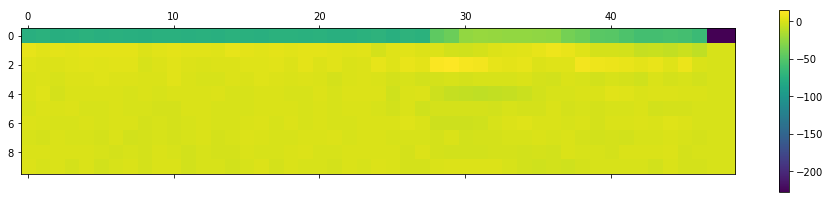

In [19]:
# Plot the MFCC features
plt.matshow(mfcc_feat_py)
plt.colorbar()
plt.show()

In [20]:
# Quantize MFCC features
quant_mfcc_feat = quantize_input(mfcc_feat_py)

## Classifying the pre-processed audio on the FPGA

In [21]:
# Run inference on the FPGA
accel.batch_size = 1
res_acc = accel.execute(quant_mfcc_feat)

In [22]:
res_label = tf_dataset_labels[res_acc[0,0].astype(np.int)]
print(f"The audio file was classified as: {res_label}")

The audio file was classified as: yes


If everything went well you should see the audio file being classified correctly.

However,you may notice that the 'down' sample is wrongly classified as 'go'. This is likely a side effect of the KWS network being a very simple architecture. This means that the network works better for some classes than others.

In [ ]:
sample_classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
for sample_class in sample_classes:
    rate, raw_signal = wav.read(f"{audio_samples_folder}audio_sample_{sample_class}.wav")
    mfcc_feat_py = py_speech_preprocessing(raw_signal, rate)
    quant_mfcc_feat = quantize_input(mfcc_feat_py)
    accel.batch_size = 1
    res_acc = accel.execute(quant_mfcc_feat)
    res_label = tf_dataset_labels[res_acc[0,0].astype(np.int)]
    print(f"The audio file for {sample_class} was classified as: {res_label}")